In [1]:
!pip install transformers

In [2]:
!pip install ml_things

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.8 MB/s eta 0:00:00
  Created wheel for ml_things: filename=ml_things-0.0.1-py3-none-any.whl size=24393 sha256=43cb8fa2ba1c51db70deec49801e3ec4787716c9244a05dc87b548026115b300
  Stored in directory: /root/.cache/pip/wheels/2a/b9/36/3725744c1d8ebec00cd847c9461b4352ce08de9d3f20b6bdcf
Successfully built ml_things


In [8]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/final_project/data/NVDA_combined_data-3.csv /content

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)


In [5]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
import pandas as pd


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
df = pd.read_csv("NVDA_combined_data-3.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
df = df[df['Description'] != '[Removed]']
df = df.dropna(subset=['Description'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 766 entries, 0 to 804
Data columns (total 7 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               766 non-null    object 
 1   Description                        766 non-null    object 
 2   Author                             752 non-null    object 
 3   Sentiment                          766 non-null    object 
 4   Severity                           766 non-null    int64  
 5   Stock_Price_difference             766 non-null    float64
 6   Stock_Price_Percentage_difference  766 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 47.9+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Description,Author,Sentiment,Severity,Stock_Price_difference,Stock_Price_Percentage_difference
0,2024-04-29,If you've been planning on buying an Apple Wat...,Jeff Dunn,Neutral,1,-11.93,-0.013619
1,2024-04-29,Meta broke its own lobbying record and easily ...,Lauren Feiner,Negative,3,-11.93,-0.013619
2,2024-04-29,With the creators of Fallout enjoying a new su...,Sophie Atkinson,Positive,2,-11.93,-0.013619
3,2024-04-29,"For Amazon Gaming Week, there are some Razer B...",Briley Kenney,Positive,2,-11.93,-0.013619
4,2024-04-29,Fallout is a huge success for Amazon Prime Vid...,Joe Allen,Positive,1,-11.93,-0.013619
...,...,...,...,...,...,...,...
800,2024-04-02,The SpringHill Company cofounder Maverick Cart...,Lauren Edmonds,Neutral,2,5.16,0.005834
801,2024-04-02,Upgrade to our favorite budget 4K TV with huge...,Oliver Haslam,Positive,1,5.16,0.005834
802,2024-04-02,You can put a pair of Apple's AirPods 2 in you...,Adam Oram,Neutral,2,5.16,0.005834
803,2024-04-02,Select independently determines what we cover ...,aol.com,Neutral,1,5.16,0.005834


In [14]:
y = df['Stock_Price_Percentage_difference'].apply(lambda x: 4 if x >= 0.06 else (3 if x >= 0.015 and x <= 0.06 \
  else (2 if x >= -0.015 and x <= 0.015 \
        else (1 if x <= -0.015 and x >= -0.06 \
              else 0
              ))))
df['labels'] = y

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Description,Author,Sentiment,Severity,Stock_Price_difference,Stock_Price_Percentage_difference,labels
0,2024-04-29,If you've been planning on buying an Apple Wat...,Jeff Dunn,Neutral,1,-11.93,-0.013619,2
1,2024-04-29,Meta broke its own lobbying record and easily ...,Lauren Feiner,Negative,3,-11.93,-0.013619,2
2,2024-04-29,With the creators of Fallout enjoying a new su...,Sophie Atkinson,Positive,2,-11.93,-0.013619,2
3,2024-04-29,"For Amazon Gaming Week, there are some Razer B...",Briley Kenney,Positive,2,-11.93,-0.013619,2
4,2024-04-29,Fallout is a huge success for Amazon Prime Vid...,Joe Allen,Positive,1,-11.93,-0.013619,2
...,...,...,...,...,...,...,...,...
800,2024-04-02,The SpringHill Company cofounder Maverick Cart...,Lauren Edmonds,Neutral,2,5.16,0.005834,2
801,2024-04-02,Upgrade to our favorite budget 4K TV with huge...,Oliver Haslam,Positive,1,5.16,0.005834,2
802,2024-04-02,You can put a pair of Apple's AirPods 2 in you...,Adam Oram,Neutral,2,5.16,0.005834,2
803,2024-04-02,Select independently determines what we cover ...,aol.com,Neutral,1,5.16,0.005834,2


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


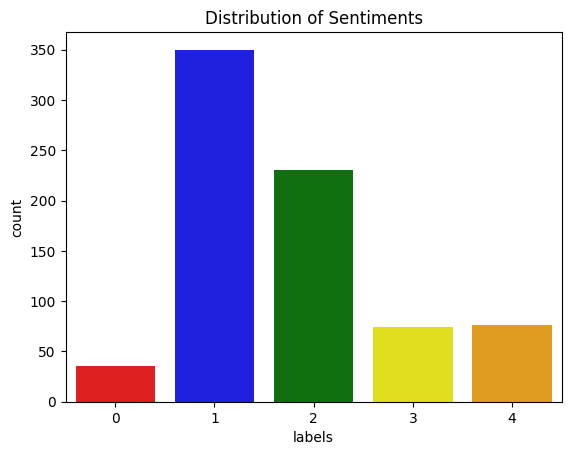

In [16]:
import matplotlib.pyplot as plt
import re
import seaborn as sns


# Exploratory Data Analysis
# Plotting the distribution of sentiments
# This dataset is balanced, each class is almost equally represented
# sns.countplot(x='sentiment', data=df)
sns.countplot(x='labels', data=df, palette=['red', 'blue','green', 'yellow','orange'], hue='labels',legend=False)
plt.title("Distribution of Sentiments")
plt.show()

In [17]:
# X = df['TEXT']
# X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
class NewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, tokenizer, max_length=768):
    super(NewsDataset).__init__()
    self.texts = df['Description'].tolist()
    self.labels=df['labels'].tolist()
    self.news_sentiments = df['Sentiment'].tolist()
    self.severities = df['Severity'].tolist()
    self.authors=df['Author'].tolist()

    # Number of exmaples.
    self.n_examples = len(self.labels)

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for i, txt in enumerate(self.texts):
      text = f'''
      Your task is to predict the sentiment of stock price of Nvidia based on on the news content, the sentiment of the news,
      severity of these news, which means how important this news can influence Nvidia's stock price, and the author of the news.
      A output of 0 means stock price likely will decrease by more than 8% tomorrow.
      A output of 1 means stock price likely will decrease by more than 1% but less than 8% tomorrow.
      A output of 2 means stock price likely will change by less than 2% tomorrow.
      A output of 3 means stock price likely will increase by more than 5% but less than 10% tomorrow tomorrow.
      A output of 4 means stock price likely will increase by more than 10% tomorrow.
      The severity score of the news is {self.severities[i]}.
      The sentiment of the news is {self.news_sentiments[i]}.
      The author of the news is {self.authors[i]}

      Content of the news: {txt}
      '''

      encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx], self.labels[idx]#, self.credibilities[idx], self.severities[idx]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
import torch
from transformers import GPT2Model, GPT2Tokenizer
from torch import nn

class NewsClassifierModel(nn.Module):
    def __init__(self, config, num_additional_features=2, num_classes=5):
        super(NewsClassifierModel, self).__init__()
        # self.gpt_model = GPT2Model(config)
        self.gpt_model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2', config=config)
        self.config = config

        # self.additional_features_fc = nn.Linear(num_additional_features, self.gpt_model.config.n_embd)
        self.gpt_model.resize_token_embeddings(len(tokenizer))
        self.gpt_model.config.pad_token_id = self.gpt_model.config.eos_token_id
        self.gpt_model.to(device)
        # self.dropout = nn.Dropout(gpt_model.config.dropout_rate)
        # self.classifier = nn.Linear(self.gpt_model.config.n_embd, num_classes)
        # self.softmax = nn.Softmax()

    def forward(self, b_input_ids, b_labels, b_masks):
        # Extract text embeddings from the GPT model
        # batch_size, sequence_length = b_input_ids.shape[:2]
        # if self.config.pad_token_id is None:
        #     sequence_lengths = -1
        # else:
        #     if b_input_ids is not None:
        #         sequence_lengths = torch.ne(b_input_ids, self.config.pad_token_id).sum(-1) - 1
        #     else:
        #         sequence_lengths = -1
        # text_outputs = self.gpt_model(  b_input_ids,
        #                   attention_mask = b_masks,
        #                   token_type_ids=None
        #                 )
        # print(sequence_lengths)
        # text_outputs = text_outputs[0]

        # # Process additional integer values
        # concat_severities_creds = concat_severities_creds.float()
        # feature_output = self.additional_features_fc(concat_severities_creds)

        # # Concatenate or add the additional features to the text embeddings
        # combined_embeddings = text_outputs + feature_output.unsqueeze(1)

        # # Apply dropout for regularization
        # # Pass the combined embeddings through the classifier
        # logits = self.classifier(combined_embeddings)
        # pooled_logits = logits[range(batch_size), sequence_lengths]
        # pooled_logits = self.softmax(pooled_logits)
        # print('pooled_logits', pooled_logits.shape)
        out = self.gpt_model(  b_input_ids,
                          attention_mask = b_masks,
                            labels=b_labels,
                          token_type_ids=None

                        )
        loss, logits = out[:2]

        return loss, logits

# Example usage
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# gpt_model = GPT2Model.from_pretrained('gpt2')

# Define the number of additional features and classes
num_additional_features = 2  # Adjust as needed
num_classes = 5  # Number of classes for classification

# Initialize custom classifier model


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [21]:
class NewsClassifierModelWithSoftmaxClassiferLayer(nn.Module):
    def __init__(self, config, num_additional_features=2, num_classes=5):
        super(NewsClassifierModel, self).__init__()
        self.gpt_model = GPT2Model.from_pretrained('gpt2')
        self.config = config
        self.additional_features_fc = nn.Linear(num_additional_features, self.gpt_model.config.n_embd)
        self.gpt_model.resize_token_embeddings(len(tokenizer))
        self.gpt_model.config.pad_token_id = self.gpt_model.config.eos_token_id
        self.gpt_model.to(device)
        # self.dropout = nn.Dropout(gpt_model.config.dropout_rate)
        self.classifier = nn.Linear(self.gpt_model.config.n_embd, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, b_input_ids, b_labels, b_masks, concat_severities_creds):

        batch_size, sequence_length = b_input_ids.shape[:2]

        if self.config.pad_token_id is None:
            sequence_lengths = -1
        else:
            if b_input_ids is not None:
                sequence_lengths = torch.ne(b_input_ids, self.config.pad_token_id).sum(-1) - 1
            else:
                sequence_lengths = -1
        text_outputs = self.gpt_model(  b_input_ids,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        print(sequence_lengths)
        text_outputs = text_outputs[0]

        # Process additional integer values
        concat_severities_creds = concat_severities_creds.float()
        feature_output = self.additional_features_fc(concat_severities_creds)
        # Concatenate or add the additional features to the text embeddings
        combined_embeddings = text_outputs + feature_output.unsqueeze(1)

        # Apply dropout for regularization
        # combined_embeddings = self.dropout(combined_embeddings)

        # Pass the combined embeddings through the classifier
        logits = self.classifier(combined_embeddings)
        pooled_logits = logits[range(batch_size), sequence_lengths]
        pooled_logits = self.softmax(pooled_logits)

        return pooled_logits

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

news_dataset = NewsDataset(tokenizer=tokenizer)

train_length=int(0.7* len(news_dataset))

test_length=len(news_dataset)-train_length

train_dataset,test_dataset=torch.utils.data.random_split(news_dataset,(train_length,test_length))

train_dataloader=torch.utils.data.DataLoader(train_dataset,
        batch_size=2, shuffle=True)
val_dataloader=torch.utils.data.DataLoader(test_dataset,
        batch_size=1, shuffle=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
len(train_dataset)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


536

In [24]:
len(test_dataset)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


230

In [25]:
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='gpt2', num_labels=5)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = NewsClassifierModel(model_config)


# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Loading configuraiton...
Loading tokenizer...
Loading model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [26]:

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = 5
epochs = 10
learning_rate = 5e-3
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
train_losses = []
val_losses = []
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    total_train_loss = 0
    total_eval_loss = 0

    model.train()

    criterion = nn.CrossEntropyLoss()
    for step, batch in enumerate(train_dataloader):
        # print(batch)
        b_input_ids = batch[0].to(device)
        b_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)
        # b_credibilities= batch[3].to(device)
        # b_severities= batch[4].to(device)
        # b_cred_severities = torch.cat((b_credibilities, b_severities))

        model.zero_grad()

        loss, logits = model(  b_input_ids,
                          b_labels,
                          b_attn_masks
                          # b_cred_severities
                        )
        # loss.retain_grad()
        # print('loss', loss.item())
        # print('logits ', logits)
        total_train_loss += loss


        # loss = criterion(logits, b_labels)
        # print('loss.grad', loss.grad)
        loss.backward()
        # print('loss.grad', loss.grad)
        optimizer.step()
        # print('loss.grad', loss.grad)
        scheduler.step()
    # print('total loss', total_train_loss)
    model.eval()
    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            loss, logits = model(b_input_ids,
#                            token_type_ids=None,
                                 b_labels,
                             b_attn_masks
                                 )
        val_loss = loss.item()
        total_eval_loss += val_loss
    avg_val_loss = total_eval_loss / len(val_dataloader)
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print("  Train Loss: {0:.2f}".format(avg_train_loss), "  Validation Loss: {0:.2f}".format(avg_val_loss))

        # print('model.gpt_model.score.weight.grad ', model.gpt_model.score.weight.grad)

    #     loss = outputs[0]

    #     batch_loss = loss.item()
    #     total_train_loss += batch_loss

    #     # Get sample every x batches.
    #     if step % sample_every == 0 and not step == 0:

    #         elapsed = format_time(time.time() - t0)
    #         print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

    #         model.eval()

    #         sample_outputs = model.generate(
    #                                 bos_token_id=random.randint(1,30000),
    #                                 do_sample=True,
    #                                 top_k=50,
    #                                 max_length = 200,
    #                                 top_p=0.95,
    #                                 num_return_sequences=1
    #                             )
    #         for i, sample_output in enumerate(sample_outputs):
    #               print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

    #         model.train()

    #     loss.backward()

    #     optimizer.step()

    #     scheduler.step()

    # # Calculate the average loss over all of the batches.
    # avg_train_loss = total_train_loss / len(train_dataloader)

    # # Measure how long this epoch took.
    # training_time = format_time(time.time() - t0)

    # print("")
    # print("  Average training loss: {0:.2f}".format(avg_train_loss))
    # print("  Training epoch took: {:}".format(training_time))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



======== Epoch 1 / 10 ========
Training...
  Train Loss: 1.52   Validation Loss: 1.37

======== Epoch 2 / 10 ========
Training...
  Train Loss: 1.40   Validation Loss: 1.31

======== Epoch 3 / 10 ========
Training...
  Train Loss: 1.37   Validation Loss: 1.58

======== Epoch 4 / 10 ========
Training...
  Train Loss: 1.35   Validation Loss: 1.32

======== Epoch 5 / 10 ========
Training...
  Train Loss: 1.36   Validation Loss: 1.33

======== Epoch 6 / 10 ========
Training...
  Train Loss: 1.34   Validation Loss: 1.35

======== Epoch 7 / 10 ========
Training...
  Train Loss: 1.21   Validation Loss: 1.35

======== Epoch 8 / 10 ========
Training...
  Train Loss: 1.05   Validation Loss: 1.46

======== Epoch 9 / 10 ========
Training...
  Train Loss: 0.97   Validation Loss: 1.63

======== Epoch 10 / 10 ========
Training...


KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


tensor([[-2.0251,  1.5193,  1.1536, -1.2109, -1.3569]], device='cuda:0')
[1] tensor([1], device='cuda:0')
tensor([[-1.5471,  0.8212,  1.1159, -0.6779, -0.7369]], device='cuda:0')
[2] tensor([3], device='cuda:0')
tensor([[-1.3577,  0.8687,  0.9314, -0.7581, -0.5365]], device='cuda:0')
[2] tensor([1], device='cuda:0')
tensor([[-1.1083,  0.2991,  0.9608, -0.2621, -0.0754]], device='cuda:0')
[2] tensor([2], device='cuda:0')
tensor([[-0.5594, -0.2973,  0.8702,  0.0925,  0.4429]], device='cuda:0')
[2] tensor([1], device='cuda:0')
tensor([[-1.7261,  1.1175,  1.0550, -0.8559, -0.9009]], device='cuda:0')
[1] tensor([1], device='cuda:0')
tensor([[-0.8387,  0.1515,  0.8382, -0.2839,  0.0582]], device='cuda:0')
[2] tensor([4], device='cuda:0')
tensor([[-0.7740,  0.0692,  0.9334, -0.1717,  0.1495]], device='cuda:0')
[2] tensor([4], device='cuda:0')
tensor([[-1.1854,  0.4517,  0.9526, -0.3997, -0.2385]], device='cuda:0')
[2] tensor([4], device='cuda:0')
tensor([[-1.3304,  0.7047,  0.9408, -0.5578, -

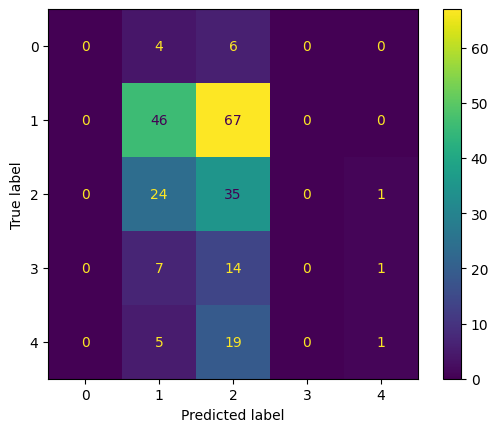

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_preds = []
y_labels = []
model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient tracking during inference
    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_attn_masks = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            loss, logits = model(b_input_ids,
                                 b_labels,
                             b_attn_masks
                                 )
            print(logits)
            y_pred = torch.argmax(logits, dim=1).cpu().numpy()
            y_preds.append(torch.argmax(logits, dim=1).cpu().numpy())
            y_labels.append(b_labels.cpu().numpy())
            print(y_pred, b_labels)

cm = confusion_matrix(y_labels, y_preds)
ConfusionMatrixDisplay(cm).plot()